In [2]:
import time
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

params = {
    # 'font.family': 'Inter',
    'font.family': 'sans-serif',
    'legend.fontsize': 'x-small',
    'axes.labelsize': 'x-small',
    'axes.titlesize': 'x-small',
    'xtick.labelsize': 'x-small',
    'ytick.labelsize': 'x-small',
    # 'figure.figsize': (3.0, 1.7),
}
plt.rcParams.update(params)
plt.clf()

def parse_timestamp(timestamp_str):
    # 2024-04-12 14:45:40.00857
    # to datetime object
    return pd.to_datetime(timestamp_str, format='%Y-%m-%d %H:%M:%S.%f')

def parse_func_name(func_name_str):
    # Func:'load_index' => "load_index"
    str_l = func_name_str.split(":")
    if "completed" in func_name_str:
        return func_name_str
    return str_l[-1][:]

def parse_latency(time_str):
    return float(time_str[:-1])

def create_gantt_chart(load_index_hbars, search_index_hbars, figsize=(6, 1), ax=None, vline=True):
    return_ax = False
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        return_ax = True

    bar_width = 0.5
    bar_gap = 0.0
    # [(x, length), ()], (y, bar_width)
    ax.broken_barh(load_index_hbars[:], (1, bar_width), facecolors =('darkorange'))
    ax.broken_barh(search_index_hbars[:], (1+bar_width+bar_gap, bar_width), facecolors =('green'))

    ax.set_yticks([1+bar_width/2, 1+bar_width+bar_gap+bar_width/2], ['load', 'search'])
    # ax.grid(True, alpha=0.5)

    if vline:
        last_x = search_index_hbars[-1][0]+search_index_hbars[-1][1]
        ax.axvline(x=last_x, color='black', linestyle='--', alpha=1)

    if return_ax:
        return fig, ax
    return ax

log_headers = ["timesteps", "start_time", "action", "latency", "file_path", "num_query"]

<Figure size 640x480 with 0 Axes>

In [3]:
def construct_load_search_bars(fpths, log_headers):
    df = pd.read_csv(fpths, header=None)
    df.columns = log_headers
    df["action"] = df["action"].map(parse_func_name)
    df["latency"] = df["latency"].map(parse_latency)
    df['start_time'] = df['start_time'] - df['start_time'][0]
    load_index_hbars = []
    search_index_hbars = []
    for i, row in df[df["action"] == "load_index"].iterrows():
        load_index_hbars.append((row["start_time"], row["latency"]))
    for i, row in df[df["action"] == "query_index"].iterrows():
        search_index_hbars.append((row["start_time"], row["latency"]))
    return load_index_hbars, search_index_hbars

In [4]:
st = "index_async"
total_idx = 1000
mem_list = []
for i in np.arange(0, 1.1, 0.1):
    mem_list.append(int(total_idx * i))

diverse_list = []
for i in np.arange(0, 1.1, 0.1):
    diverse_list.append(i)

for m in diverse_list:
    # if m==0: m=1
    fp = "../logs/st_{}_{}_batch.log".format(st, m)
    print(fp)
    try:
        l, s = construct_load_search_bars(fp, log_headers)
        fig, ax = create_gantt_chart(l, s, ax=None)
        fig.tight_layout()
        fig.savefig("tmp/st_{}_{}_batch.pdf".format(st, m))
        plt.show()
    except:
        pass

../logs/st_index_async_0.0_batch.log
../logs/st_index_async_0.1_batch.log
../logs/st_index_async_0.2_batch.log
../logs/st_index_async_0.30000000000000004_batch.log
../logs/st_index_async_0.4_batch.log
../logs/st_index_async_0.5_batch.log
../logs/st_index_async_0.6000000000000001_batch.log
../logs/st_index_async_0.7000000000000001_batch.log
../logs/st_index_async_0.8_batch.log
../logs/st_index_async_0.9_batch.log
../logs/st_index_async_1.0_batch.log


In [5]:
st_query = {1: 153.61743285,
            100: 24.90386106,
            200: 9.29645746,
            300: 8.65851302,
            400: 8.57795881,
            500: 8.80642473,
            600: 9.36062568,
            700: 8.60914782,
            800: 8.61208765,
            900: 8.47547708,
            1000: 8.74988525}

st_index = {
    1: 0.81666721,
    100: 0.81620806,
    200: 0.77503797,
    300: 0.77260581,
    400: 0.74566446,
    500: 0.75055806,
    600: 0.82484493,
    700: 0.78199837,
    800: 0.75145365,
    900: 0.75596289,
    1000: 0.77090119
}

st_index_async = {
    1: 0.73935232,
    100: 0.55480419,
    200: 0.55719207,
    300: 0.51906040,
    400: 0.53654169,
    500: 0.55858433,
    600: 0.56641869,
    700: 0.56285429,
    800: 0.55761006,
    900: 0.53367700,
    1000: 0.53802682
}

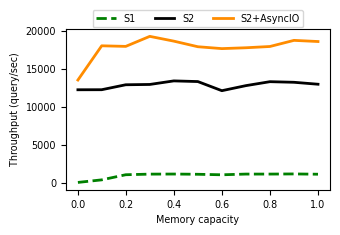

In [9]:
# compute tput query per sec
num_query = 10000
max_mem = 1000

tput_query = {}
for k, v in st_query.items():
    k = k / max_mem
    tput_query[k] = num_query / v

tput_index = {}
for k, v in st_index.items():
    k = k / max_mem
    tput_index[k] = num_query / v

tput_index_async = {}
for k, v in st_index_async.items():
    k = k / max_mem
    tput_index_async[k] = num_query / v

# plot tput
linewidth = 2
plt.figure(figsize=(3.5, 2.5))
plt.plot(list(tput_query.keys()), list(tput_query.values()), label="S1", color='green', linewidth=linewidth, linestyle='--')
plt.plot(list(tput_index.keys()), list(tput_index.values()), label="S2", color='black', linewidth=linewidth)
plt.plot(list(tput_index_async.keys()), list(tput_index_async.values()), label="S2+AsyncIO", color='darkorange', linewidth=linewidth)

# 1 row, 3 columns legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
plt.xlabel("Memory capacity")
plt.ylabel("Throughput (query/sec)")
plt.tight_layout()
plt.savefig("tmp/tput_mem.pdf")
plt.show()

In [142]:
# query diversity

st_query_diversity = {
    0.0: 9.43839952,
    0.1: 10.93816875,
    0.2: 10.70763876,
    0.3: 11.00994852,
    0.4: 12.05738855,
    0.5: 11.16794533,
    0.6: 11.23277323,
    0.7: 13.44501039,
    0.8: 11.27035343,
    0.9: 11.34796564,
    1.0: 11.30618735
}


st_index_diversity = {
    0.0: 1.14276421,
    0.1: 1.95855080,
    0.2: 1.83449230,
    0.3: 1.89141592,
    0.4: 1.88526955,
    0.5: 1.89281210,
    0.6: 1.88903056,
    0.7: 1.90273121,
    0.8: 1.96149863,
    0.9: 1.92830793,
    1.0: 1.94605508
}


st_index_async_diversity = {
    0.0: 0.78801695,
    0.1: 1.55864374,
    0.2: 1.40223565,
    0.3: 1.39977139,
    0.4: 1.40591503,
    0.5: 1.38263734,
    0.6: 1.41171381,
    0.7: 1.45423789,
    0.8: 1.47577877,
    0.9: 1.46389665,
    1.0: 1.49676419
}


# convert to query per sec
tput_query_diversity = {}
for k, v in st_query_diversity.items():
    tput_query_diversity[str(k)[:3]] = num_query / v

tput_index_diversity = {}
for k, v in st_index_diversity.items():
    tput_index_diversity[str(k)[:3]] = num_query / v

tput_index_async_diversity = {}
for k, v in st_index_async_diversity.items():
    tput_index_async_diversity[str(k)[:3]] = num_query / v

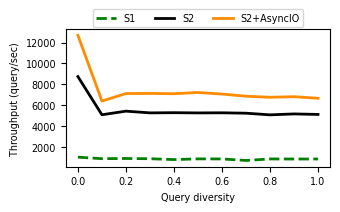

In [124]:
# plot
plt.figure(figsize=(3.5, 2.3))
plt.plot(list(tput_query_diversity.keys()), list(tput_query_diversity.values()), label="S1", color='green', linewidth=linewidth, linestyle='--')
plt.plot(list(tput_index_diversity.keys()), list(tput_index_diversity.values()), label="S2", color='black', linewidth=linewidth)
plt.plot(list(tput_index_async_diversity.keys()), list(tput_index_async_diversity.values()), label="S2+AsyncIO", color='darkorange', linewidth=linewidth)

# 1 row, 3 columns legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=3)
plt.xlabel("Query diversity")
plt.ylabel("Throughput (query/sec)")
plt.tight_layout()
plt.savefig("tmp/tput_diversity.pdf")
plt.show()

In [155]:
# compute percentage tput change compared to previous

def random_floats(size, low=0, high=1, seed=None):
    # if seed is not None: np.random.seed(seed)
    return [np.random.uniform(low, high) for _ in range(size)]

random_floats(1, -1., 1)[0]

-0.12596262729744656

In [12]:
np.random.seed(0)
np.random.uniform(-1, 1, (1, 2))

array([[0.09762701, 0.43037873]])